In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, concatenate, dot, Dense, Dropout, BatchNormalization, multiply, add

## Loading and preprocessing data:

In [2]:
df_reviews = pd.read_csv(f'../data/reviews.csv')
df_restos = pd.read_csv(f'../data/restaurants.csv')
df_users = pd.read_csv(f'../data/users.csv')

In [3]:
num_users = df_reviews.user_code.max()+1 # number of users
num_items = df_reviews.resto_code.max()+1 # number of items

In [4]:
# train/test split

df_reviews = df_reviews.sort_values(by='time')
df_test = df_reviews.groupby('user_id').tail(3)  # put in test set 3 most recent reviews for each user
df_train = pd.concat([df_reviews, df_test, df_test]).drop_duplicates(keep=False)

## Defining the Neural Collaborative Filtering model:

In [5]:
latent_dim = 20

# Define inputs
item_input = Input(shape=[1],name='item-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
item_embedding_mlp = Embedding(num_items + 1, latent_dim, name='item-embedding-mlp')(item_input)
item_vec_mlp = Flatten(name='flatten-item-mlp')(item_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
item_embedding_mf = Embedding(num_items + 1, latent_dim, name='item-embedding-mf')(item_input)
item_vec_mf = Flatten(name='flatten-item-mf')(item_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([item_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)

fc_0 = Dense(200, name='fc-0', activation='relu')(concat_dropout)
fc_0_bn = BatchNormalization(name='batch-norm-0')(fc_0)
fc_0_dropout = Dropout(0.2)(fc_0_bn)

fc_1 = Dense(100, name='fc-1', activation='relu')(fc_0_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)

fc_2 = Dense(20, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = multiply([item_vec_mf, user_vec_mf], name='pred-mf')
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, item_input], result)
model.compile(optimizer=SGD(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item-embedding-mlp (Embedding)  (None, 1, 20)       1847300     ['item-input[0][0]']             
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 20)       14013000    ['user-input[0][0]']             
                                                                                              

## Training the model:

Epoch 1/15
227412/227412 [==============================] - 446s 2ms/step - loss: 1.1159 - mae: 0.8346 - val_loss: 1.1102 - val_mae: 0.8312
Epoch 2/15
227412/227412 [==============================] - 426s 2ms/step - loss: 1.0898 - mae: 0.8198 - val_loss: 1.0581 - val_mae: 0.7985
Epoch 3/15
227412/227412 [==============================] - 477s 2ms/step - loss: 0.9950 - mae: 0.7666 - val_loss: 0.9794 - val_mae: 0.7491
Epoch 4/15
227412/227412 [==============================] - 459s 2ms/step - loss: 0.9082 - mae: 0.7142 - val_loss: 0.9317 - val_mae: 0.6938
Epoch 5/15
227412/227412 [==============================] - 411s 2ms/step - loss: 0.8684 - mae: 0.6881 - val_loss: 0.9094 - val_mae: 0.6768
Epoch 6/15
227412/227412 [==============================] - 400s 2ms/step - loss: 0.8495 - mae: 0.6752 - val_loss: 0.8840 - val_mae: 0.6983
Epoch 7/15
227412/227412 [==============================] - 376s 2ms/step - loss: 0.8386 - mae: 0.6677 - val_loss: 0.8753 - val_mae: 0.6806
Epoch 8/15
227412/22

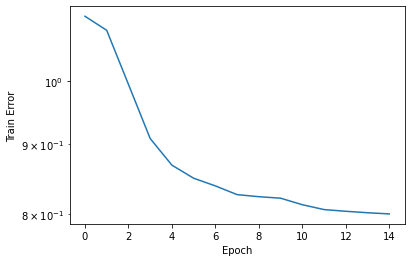

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([df_train.user_code, df_train.resto_code], df_train.rating, batch_size=64, epochs=15,
                    validation_data=([df_test.user_code, df_test.resto_code], df_test.rating), verbose=1)

pd.Series(history.history['loss']).plot(logy=True, c='purple')
pd.Series(history.history['val_loss']).plot(logy=True, c='orange')
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

In [16]:
# saving the model
model.save('ncf_model.h5')

## Using the model to make predictions:

In [21]:
# trying the model on random reviews

nb_tests = 10
for i in range(nb_tests):
    rating_row = df_reviews.iloc[np.random.randint(0, len(df_reviews))]
    user_code, resto_code, rating = rating_row.user_code, rating_row.resto_code, rating_row.rating
    print(f'User {df_users[df_users.user_code == user_code].user_id.values[0]} for restaurant {df_restos[df_restos.resto_code == resto_code].name.values[0]}')
    print(f'Predicted rating: {model.predict([np.array([user_code]), np.array([resto_code])])[0][0]:.2f}')
    print(f'True rating: {rating:.2f}')


User 117743287435898944737 for restaurant Las Enchiladas Restaurant
1/1 [==============================] - 0s 27ms/step
Predicted rating: 3.78
True rating: 3.00
User 114998415190162973194 for restaurant Taquería El Grullo
1/1 [==============================] - 0s 37ms/step
Predicted rating: 4.83
True rating: 5.00
User 105963301480595908847 for restaurant El Pescador
1/1 [==============================] - 0s 27ms/step
Predicted rating: 4.53
True rating: 5.00
User 118298202335776142340 for restaurant Lala's Waffles Crepes & Shakes
1/1 [==============================] - 0s 25ms/step
Predicted rating: 3.32
True rating: 3.00
User 116235568884589886022 for restaurant Shakey's Pizza Parlor
1/1 [==============================] - 0s 24ms/step
Predicted rating: 4.54
True rating: 5.00
User 106827666242459607121 for restaurant Little Caesars Pizza
1/1 [==============================] - 0s 21ms/step
Predicted rating: 4.52
True rating: 5.00
User 111181436734386266929 for restaurant Pomme Frite
1/1 [